# Sports Betting Using Handicapper Data

Submitted by:
* Ji Zheng
* Ye (Kevin) Pang
* Jay Zuniga

Date: April 18, 2018

Web data scrapped from https://www.sportschatexperts.com/index/cappers/

## Contents <a name='top' />

* <a href='#background'>Background</a>
* <a href='#data'>Data Preparation</a>
* <a href='#eda'>Exploratory Analysis</a>
* <a href='#modeldata'>Splitting Data into Training and Testing</a>
* <a href='#knn'>k-Nearest Neighbors (kNN)</a>
* <a href='#nb'>Naive Bayes (NB)</a>
* <a href='#lr'>Logistic Regression (LR)</a>
* <a href='#rf'>Random Forest (RF)</a>
* <a href='#gbm'>Gradient Boosting Machine (GBM)</a>
* <a href='#svm'>Support Vector Machines (SVM) **did not run**</a>
* <a href='#kmeans'>K-means Clustering **not useful**</a>
* <a href='#gmm'>Gaussian Mixture Model (GMM) **not useful**</a>
* <a href='#dnn'>Multilayer Perceptron</a>
* <a href='#ensemble'>Our Strategy On Money-Line Bets</a>
* <a href='#appendix_a'>Appendix A - Feature Importance From Random Forest Model</a>
* <a href='#appendix_b'>Appendix B - Random Forest Model on Pivoted Data & Feature Importance</a>

## Background <a name='background' />

<a href='#top'>[Back to Contents]</a>

Sports Betting has become a very big market in the USA, with the legal side estimated at over 4 Billion USD and the total market estimated at 150 Billion USD. As a response to this market, handicappers have started offering their predictions, usually for a fee. Handicappers offer their predictions on specific games.

Our team aims to use machine learning to find out the following:
1. Are handicappers' predictions useful?
2. Can models be used to generalize a handicapper's betting pattern based on their historical performance data?
  * If we can do so, then we may not have to pay for their "actual" predictions.
3. Based on handicappers' predictions (either actual or simulated), can we predict the outcome of the game for automated betting?

*Please note:* We will focus on **money-line** only, since they have the least amount of setup variations compare to "spread" and "total" types of betting.

Time permitting, we will explore multiple classifiers. These are:

**Supervised**:    
- k Nearest Neighbors
- Naive Bayes
- Logistic Regression
- Random Forest
- Gradient Boosting Machines
- Support Vector Machines

**Unsupervised**:
- K-means
- Gaussian Mixture Model

**Deep learning**:
- Multilayer perceptron

## Data Preparation <a name='data' />

<a href='#top'>[Back to Contents]</a>

We used web scrapping on a popular handicapper website that houses 30 handicappers with a good coverage over a variety of sports. Then we merged the data and added additional derived performance metrics.

#### Import packages

In [70]:
import requests, bs4, hashlib, collections 
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture #gmm is deprecated, use GaussianMixture instead
from matplotlib.colors import LogNorm
from sklearn.neural_network import MLPClassifier

%matplotlib inline

#### Web scrapping 
* No need to run this step since we have saved the datasets in pickled files

In [2]:
# # Web scrapping 
# # Try an example on MIT SIMULATOR, https://www.sportschatexperts.com/index/capperhistory/capper_id/68/
# def get_html(url):
#     html = requests.get(url)
#     try:
#         html.raise_for_status()
#     except Exception as exc:
#         print('There was a problem: %s' % exc)
#     html = bs4.BeautifulSoup(html.text, "html5lib")
#     return html

# def get_next_url(html):
#     # find the next button
#     return html.find('a', string='Next')['href']

# def merge_table(url, stop_page=-1, data=[]):
#     cur_page = 0
#     while True:
#         cur_page += 1
#         if cur_page % 50 == 0:
#             print("\tProcess %s ..." % url)
#         html = get_html(url)
#         table = html.find('section', class_='leaderboards diffpadding').div.table
#         table_body = table.find('tbody')       
#         rows = table_body.find_all('tr', class_='leaderboards_row2 fix-border-bottom ph-first-row')
#         for row in rows:
#             cols = row.find_all('td')
#             # make sure the targeted row for extraction has 10 columns
#             if len(cols) == 10:
#                 # only want to keep these columns
#                 keep_columns = [1, 2, 3, 4, 5, 6, 7, 8]
#                 cols = [ele.text.strip() for ele in [cols[i] for i in keep_columns]]
#                 data.append([ele for ele in cols if ele]) # Get rid of empty values
#         url = get_next_url(html)
#         if (url == '#') or cur_page >= stop_page:
#             break
            
# def crawl_history():
#     names = [
#     'Smart',
#     'Bartley',
#     'Aronson',
#     'Burns',
#     'Barone', # not in Ji's original list
#     'Bitler',
#     'Power',
#     'Ross',
#     'Diamond',
#     'Trapp',
#     'Sports',
#     'Eddie',
#     'Schule',
#     'DAmico',
#     'Duffy',
#     'Thomas',
#     'Hunter',
#     'Compeau', # not in Ji's original list
#     'Syndicate',
#     'Lundin',
#     'Simulator',
#     'Wilson',
#     'Monohan',
#     'Vinceletti',
#     'Rickenbach',
#     'Higgs',
#     'Nover',
#     'Brown',
#     'Karpinski',
#     'Rogers'
#     ]

#     links = [
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/44/", 
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/33/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/50/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/67/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/69/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/65/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/62/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/66/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/36/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/29/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/45/", 
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/38/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/52/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/35/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/37/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/53/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/41/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/56/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/58/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/61/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/68/", 
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/30/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/43/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/46/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/57/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/40/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/51/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/42/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/60/",
#     "https://www.sportschatexperts.com/index/capperhistory/capper_id/55/",
#     ]
    
#     handicappers_dict = collections.OrderedDict(zip(names, links))
    
#     for k, v in handicappers_dict.items():
#         data=[]
#         merge_table(v, 9999, data)
#         #print(data)
#         df = pd.DataFrame(data, columns=['League', 'Game', 'Date', 'Play', 'Line Selected', 'Type', 'Score', 'Result'])
#         filename = 'HC' + str(list(handicappers_dict.keys()).index(k)+1)
        
#         # produce a hashed gamekey for the game
#         df["GameKey"] = df[['League', 'Game', 'Date']].apply(lambda x: hashlib.md5(''.join(x).encode('utf-8')).hexdigest(), axis=1)

#         # home team is always on the right?
#         df["Home"] = df["Game"].apply(lambda x: x.split('vs.')[1].strip().upper())

#         # away team is always on the left?
#         df["Away"] = df["Game"].apply(lambda x: x.split('vs.')[0].strip().upper())

#         # strip out type of bet
#         df["Bet"] = df["Line Selected"].apply(lambda x: x.split(':')[0].strip().upper())

#         # strip out which team the bet is on
#         df["On"] = df["Play"].apply(lambda x: x.split('Play on ')[1].strip().upper())

#         # convert game time to datetime format 
#         df["GameTime"] = df["Date"].apply(lambda x: pd.to_datetime(x))

#         # strip out juice
#         df["Juice"] = df["Line Selected"].apply(lambda x: x.split(': ')[1].strip() if ("Money Line" in x) else (x.split(': ')[1].split('/')[0].strip() if ("Total" in x) else x.split(': ')[1].split('/')[1].strip()))

#         # MLWinner: either home or away team for ML bets
#         conditions = [
#         (df['On'] == df['Home']) & (df['Bet'] == 'MONEY LINE') & (df['Result'] == 'Win'), 
#         (df['On'] == df['Away']) & (df['Bet'] == 'MONEY LINE') & (df['Result'] == 'Win'), 
#         (df['On'] == df['Home']) & (df['Bet'] == 'MONEY LINE') & (df['Result'] == 'Loss'), 
#         (df['On'] == df['Away']) & (df['Bet'] == 'MONEY LINE') & (df['Result'] == 'Loss')
#         ]
#         choices = ['Home', 'Away', 'Away', 'Home']
#         df['MLWinner'] = np.select(conditions, choices, default='')

#         # MLBet: either home or away team for ML bets
#         conditions = [
#         (df['On'] == df['Home']) & (df['Bet'] == 'MONEY LINE'), 
#         (df['On'] == df['Away']) & (df['Bet'] == 'MONEY LINE')
#         ]
#         choices = ['Home', 'Away']
#         df['MLBet'] = np.select(conditions, choices, default='')
        
#         columns_to_keep = ['League', 'GameKey', 'GameTime', 
#                    'Home', 'Away',
#                    'Bet', 'On',
#                    'Juice', 'Type', 'Result',
#                    'MLBet', 'MLWinner']
#         #print(df[columns_to_keep].head())
#         df[columns_to_keep].to_pickle(k + '.gz', compression="gzip")       

# crawl_history()

#### Concatenate and load all 30 handicappers' betting histories into one dataframe

In [3]:
# merge hadicappers' history bets into one dataframe
names = [
    'Smart',
    'Bartley',
    'Aronson',
    'Burns',
    'Barone', # not in Ji's original list
    'Bitler',
    'Power',
    'Ross',
    'Diamond',
    'Trapp',
    'Sports',
    'Eddie',
    'Schule',
    'DAmico',
    'Duffy',
    'Thomas',
    'Hunter',
    'Compeau', # not in Ji's original list
    'Syndicate',
    'Lundin',
    'Simulator',
    'Wilson',
    'Monohan',
    'Vinceletti',
    'Rickenbach',
    'Higgs',
    'Nover',
    'Brown',
    'Karpinski',
    'Rogers'
    ]

df = pd.DataFrame()
for i in range(1,31): 
    newdf = pd.read_pickle('HC' + str(i) + '.gz', compression='gzip')
    
    # if you want the last name of the HC, switch to use names array
    #newdf['Handicapper'] = names[i-1]
    newdf['Handicapper'] = 'HC'+str(i)
    df = df.append(newdf, ignore_index=True)

#### The following functions derive additonal handicapper attributes from the historical bets

 * number of wins in the past 30 games
 * percentage of wins in the past 30 games; for the 1st game, assume win % is 50%
 * active winning & losing streak counts 
 * number of wins in the past 30 games for specific sport(league)
 * percentage of wins in the past 30 games for specific sport(league); for the 1st game, assume win % is 50%
 * active winning & losing streak counts for specific sport(league)
 * risk appetite from betting 'juice' (odds)
   * if juice more than 120, then betting on 'underdog'
   * if juice less than -140, then betting on 'favorite'
   * consider everything else as betting on 'normal'
 * number of wins in the past 30 games for specific risk appetite
 * percentage of wins in the past 30 games for specific risk appetite

In [4]:
# add column for # of wins in the past 30 games
# add column for % of wins in the past 30 games
# if game is 0, assume win % is 50%
# add column for winning steak
def win_past_30_all_sport(df):
    df=df.sort_values(['Handicapper','GameTime'], ascending=[1,1])
    df=df.reset_index(drop=True)
    win_past_30=[]
    win_past_30_all_sport_percent=[]
    win_tracker=[]
    win_steak=[]
    win=0
    lose=0
    win_steak=[]
    
    pointer=0
    last=df.League.count()
    HC=df['Handicapper'][0]
    while pointer < last:
        if df['Handicapper'][pointer]!=HC:
            HC=df['Handicapper'][pointer]
            win_past_30.append(0)
            win_past_30_all_sport_percent.append(0.5)
            win_steak.append(0)
        elif pointer == 0:
            win_past_30.append(0)
            win_past_30_all_sport_percent.append(0.5)
            win_steak.append(0)
        else: 
            win_past_30.append(sum(win_tracker))
            mean = sum(win_tracker)/len(win_tracker)
            win_past_30_all_sport_percent.append(mean)
            if (win>lose):
                win_steak.append(win)
            else:
                win_steak.append(-lose)

        
        if df['Result'][pointer]=='Win':
            win_tracker.insert(0,1)
            win+=1
            lose=0
        elif df['Result'][pointer]=='Push':
            win_tracker.insert(0,1)
        else:
            win_tracker.insert(0,0)
            win=0
            lose+=1
            
            
        
        if len(win_tracker)>30:
            win_tracker.pop()
        pointer+=1

    df['win_past_30_all_sport']=win_past_30
    df['win_past_30_all_sport_percent']=win_past_30_all_sport_percent
    df['win_steak_all_sport']=win_steak
    return df
    
# add column for # of wins in the past 30 games for specific sport(league)
# add column for % of wins in the past 30 games for specific sport(league)
# if game is 0, assume win % is 50%
# add column for winning steak for specific sport(league) 
def win_past_30_specific_sport(df):
    df=df.sort_values(['Handicapper','League','GameTime'], ascending=[1,1,1])
    df=df.reset_index(drop=True)
    win_past_30=[]
    win_past_30_specific_sport_percent=[]
    win_tracker=[]
    pointer=0
    win_steak=[]
    win=0
    lose=0
    last=df.League.count()
    HC=df['Handicapper'][0]
    League=df['League'][0]
    while pointer < last:
        if (df['Handicapper'][pointer]!=HC) or (df['League'][pointer]!=League):
            HC=df['Handicapper'][pointer]
            League=df['League'][pointer]
            win_tracker=[]
            win_past_30.append(0)
            win_past_30_specific_sport_percent.append(0.5)
            win_steak.append(0)
        elif pointer == 0:
            win_past_30.append(0)
            win_past_30_specific_sport_percent.append(0.5)
            win_steak.append(0)
        else: 
            win_past_30.append(sum(win_tracker))
            mean = sum(win_tracker)/len(win_tracker)
            win_past_30_specific_sport_percent.append(mean)
            if (win>lose):
                win_steak.append(win)
            else:
                win_steak.append(-lose)
            
            
        if df['Result'][pointer]=='Win':
            win_tracker.insert(0,1)
            win+=1
            lose=0
        elif df['Result'][pointer]=='Push':
            win_tracker.insert(0,1)
        else:
            win_tracker.insert(0,0)
            win=0
            lose+=1
            
            
        if len(win_tracker)>30:
            win_tracker.pop()

        pointer+=1
    df['win_past_30_specific_sport']=win_past_30
    df['win_past_30_specific_sport_percent']=win_past_30_specific_sport_percent
    df['win_steak_specific_sport']=win_steak
    return df


## convert juice to risk level
## if juice more than 120, then we are betting on underdog
## if juice less than -140, then we are betting on favorite
## I consider everything else is 'normal'
def bet_risk(df):
    pointer=0
    bet_risk=[]
    last=df.League.count()
    while pointer < last:
        if int(df['Juice'][pointer])>120:
            bet_risk.append('underdog')
        elif int(df['Juice'][pointer])<-140:
            bet_risk.append('favorite')
        else:
            bet_risk.append('normal')
        pointer+=1
    df['bet_risk']=bet_risk
    return df

# add column for # of wins in the past 30 games for specific risk
# add column for % of wins in the past 30 games for specific risk
# if game is 0, assume win % is 50%
# add column for winning steak for specific risk
def win_past_30_specific_risk(df):
    df=df.sort_values(['Handicapper','bet_risk','GameTime'], ascending=[1,1,1])
    df=df.reset_index(drop=True)
    win_past_30=[]
    win_past_30_specific_risk_percent=[]
    win_tracker=[]
    pointer=0
    last=df.League.count()
    HC=df['Handicapper'][0]
    Risk=df['bet_risk'][0]
    while pointer < last:
        if (df['Handicapper'][pointer]!=HC) or (df['bet_risk'][pointer]!=Risk):
            HC=df['Handicapper'][pointer]
            Risk=df['bet_risk'][pointer]
            win_tracker=[]
            win_past_30.append(0)
            win_past_30_specific_risk_percent.append(0.5)
        elif pointer == 0:
            win_past_30.append(0)
            win_past_30_specific_risk_percent.append(0.5)
        else: 
            win_past_30.append(sum(win_tracker))
            mean = sum(win_tracker)/len(win_tracker)
            win_past_30_specific_risk_percent.append(mean)
        if df['Result'][pointer]=='Win':
            win_tracker.insert(0,1)
        else:
            win_tracker.insert(0,0)
        if len(win_tracker)>30:
            win_tracker.pop()

        pointer+=1
    df['win_past_30_specific_risk']=win_past_30
    df['win_past_30_specific_risk_percent']=win_past_30_specific_risk_percent
    return df

df = win_past_30_all_sport(df)
df = win_past_30_specific_sport(df)
df = bet_risk(df)
df = win_past_30_specific_risk(df)

#### Here's our processed dataset

In [5]:
print('(rows, columns):', df.shape)
print(df.columns)

(rows, columns): (134880, 22)
Index(['League', 'GameKey', 'GameTime', 'Home', 'Away', 'Bet', 'On', 'Juice',
       'Type', 'Result', 'MLBet', 'MLWinner', 'Handicapper',
       'win_past_30_all_sport', 'win_past_30_all_sport_percent',
       'win_steak_all_sport', 'win_past_30_specific_sport',
       'win_past_30_specific_sport_percent', 'win_steak_specific_sport',
       'bet_risk', 'win_past_30_specific_risk',
       'win_past_30_specific_risk_percent'],
      dtype='object')


## Exploratory Analysis <a name='eda' />

<a href='#top'>[Back to Contents]</a>

We first explored the collected historical data to get an idea what coverage the 30 handicappers provided, i.e. 1) on which sports and 2) what type of predictions 

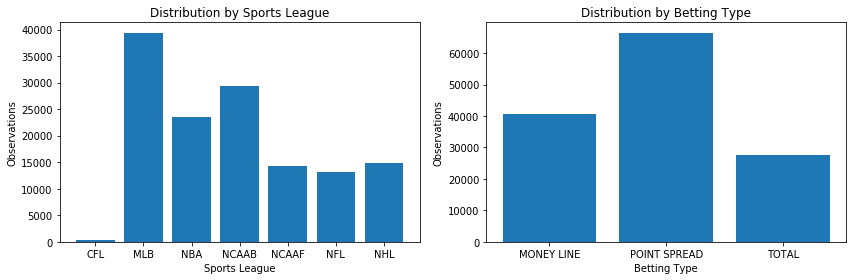

In [6]:
plt.figure(figsize=(12,4))

# Distribution according to League
plt.subplot(1, 2, 1)
plt.bar(df.sort_values(by='League').League.unique(), df.groupby(['League']).size())
plt.title('Distribution by Sports League')
plt.xlabel('Sports League')
plt.ylabel('Observations')

plt.subplot(1, 2, 2)
# Distribution according to Betting Type
plt.bar(df.sort_values(by='Bet').Bet.unique(), df.groupby(['Bet']).size())
plt.title('Distribution by Betting Type')
plt.xlabel('Betting Type')
plt.ylabel('Observations')

plt.tight_layout()

Predictions by handicappers are also not distributed similarly with some handicappers producing more than others. 
* As we can see HC22 (Wilson), is the most prolific.

In [7]:
# Top Handicapper contributions
h = df.groupby(['Handicapper']).size()
h.sort_values(ascending=False)

Handicapper
HC22    10896
HC26     8713
HC1      8437
HC24     8072
HC9      6943
HC17     6914
HC11     6626
HC30     6022
HC25     5611
HC13     5441
HC23     5432
HC3      5413
HC28     5238
HC15     5201
HC10     4401
HC12     3751
HC16     3683
HC27     3534
HC19     3312
HC29     3156
HC7      2862
HC14     2804
HC20     2669
HC2      2227
HC18     2208
HC8      1310
HC6      1246
HC4      1213
HC5       984
HC21      561
dtype: int64

Here's view on # of handicappers, and # of predictions they made by year for a total of 134,880 predictions
* 14 people have data back from 2013

In [8]:
# code
df['Win_Count']=df['Result'].apply(lambda x : 1 if x=="Win" else 0 )
df['Push_Count']=df['Result'].apply(lambda x : 1 if x=="Push" else 0 )
df['Loss_Count']=df['Result'].apply(lambda x : 1 if x=="Loss" else 0 )
df['Year']=df['GameTime'].apply(lambda x : x.year)

# code
prelim_pivot1 = pd.pivot_table(df, index=['Year'], values=['Handicapper', 'GameKey'],aggfunc = {'Handicapper': lambda x: len(x.unique()), 'GameKey': len})
prelim_pivot1 = prelim_pivot1.reindex_axis(['Handicapper', 'GameKey'], axis=1)
prelim_pivot1.columns = ['# of handicappers', '# of predictions']
prelim_pivot1

,# of handicappers,# of predictions
Year,,
2013,14,6602
2014,19,19640
2015,22,26515
2016,25,31123
2017,30,37673
2018,30,13327


The long-term win percentage of these handicappers vary between 47% and 54%. However, that's in line with betting expectation - i.e., the house has an advantage. 
* For those handicappers that have a long term performance over 50%, they probably have  strategies that worked well for them which we can leverage. 

In [9]:
prelim_pivot2 = pd.pivot_table(df,index=["Handicapper"], values=["Result", "Win_Count"], 
                        aggfunc= {"Result": len, "Win_Count": np.sum}, 
                        fill_value=0)
prelim_pivot2['Win_Percent']=prelim_pivot2['Win_Count']/prelim_pivot2['Result']
prelim_pivot2.columns = ['#_Predictions', 'Win_Count', 'Win_Percent']
prelim_pivot2.sort_values(by=['Win_Percent'], ascending = False)

,#_Predictions,Win_Count,Win_Percent
Handicapper,,,
HC13,5441,2920,0.536666
HC7,2862,1527,0.533543
HC28,5238,2757,0.526346
HC3,5413,2821,0.521153
HC4,1213,630,0.519373
HC9,6943,3606,0.519372
HC8,1310,680,0.519084
HC24,8072,4182,0.518087
HC2,2227,1151,0.516839


Similarly, we can see varied performance in their risk taking and performance.
* when betting on favorite, most people have around 60% performance
* for normal games, most people have just 50% performance, 
* for underdog bets, it is surprising to see that HC28 has over 64%

In [10]:
prelim_pivot3=pd.pivot_table(df, index=['Handicapper','bet_risk'], values=["Result", "Win_Count"], 
                        aggfunc= {"Result": len, "Win_Count": np.sum}, 
                        fill_value=0)
prelim_pivot3['Win_Percent']=prelim_pivot3['Win_Count']/prelim_pivot3['Result']
prelim_pivot4=pd.pivot_table(prelim_pivot3, index=['Handicapper'], values=["Win_Percent"], 
                        aggfunc= {"Win_Percent": np.average}, columns='bet_risk',
                        fill_value=0)
prelim_pivot4

Win_Percent                    
bet_risk       favorite    normal  underdog
Handicapper                                
HC1            0.627358  0.506692  0.397368
HC10           0.546256  0.491168  0.387755
HC11           0.610215  0.498548  0.413534
HC12           0.580952  0.506361  0.446009
HC13           0.597798  0.514129  0.426667
HC14           0.595506  0.489811  0.400000
HC15           0.568966  0.503571  0.396509
HC16           0.651007  0.484005  0.417722
HC17           0.678571  0.516273  0.382166
HC18           0.644231  0.527721  0.435459
HC19           0.628571  0.514295  0.338983
HC2            0.629630  0.514405  0.476190
HC20           0.564444  0.495791  0.294118
HC21           0.500000  0.518116  0.000000
HC22           0.587477  0.490414  0.381579
HC23           0.650407  0.505469  0.354497
HC24           0.601626  0.511027  0.452941
HC25           0.696429  0.495593  0.367673
HC26           0.714286  0.503178  0.404982
HC27           0.672897  0.512900  0.447619
HC28           0.621160  0.517148  0.649254
HC29           0.619369  0.501589  0.350515
HC3            0.614504  0.503210  0.381250
HC30           0.617106  0.492423  0.313953
HC4            0.630350  0.490052  0.000000
HC5            0.572917  0.469293  0.240000
HC6            0.619048  0.497087  0.378788
HC7            0.619377  0.512357  0.444444
HC8            0.604545  0.507069  0.310345
HC9            0.624501  0.508635  0.465035

Since we are intrested in ML bets, here's another look at the handicappers' winning percentages:
* there seem to be some new comers that did better than veterans
* there are more people in the >50% range for ML only bets compared to all bets

In [11]:
prelim_pivot5 = pd.pivot_table(df[(df['Bet']=='MONEY LINE') & (df['League']!='CFL') & (df['MLWinner'] !='')],index=["Handicapper"], values=["Result", "Win_Count"], 
                        aggfunc= {"Result": len, "Win_Count": np.sum}, 
                        fill_value=0)
prelim_pivot5['Win_Percent']=prelim_pivot5['Win_Count']/prelim_pivot5['Result']
prelim_pivot5.columns = ['#_Predictions', 'Win_Count', 'Win_Percent']
prelim_pivot5.sort_values(by=['Win_Percent'], ascending = False)

,#_Predictions,Win_Count,Win_Percent
Handicapper,,,
HC4,359,218,0.607242
HC3,1637,944,0.576665
HC7,885,507,0.572881
HC13,2437,1374,0.563808
HC28,1559,874,0.560616
HC24,2021,1120,0.554181
HC29,1282,706,0.550702
HC30,1803,992,0.550194
HC8,440,239,0.543182


## Splitting Data into Training and Testing <a name='modeldata' />

<a href='#top'>[Back to Contents]</a>

Here're our train and test data sets:
* we took bets before 7/1/2017 to be training data
* we took bets greater or equal to 7/1/2017 to be testing data
* we excluded CFL league in the model because very few data exists
* We focused on money-line only

In [119]:
non_clf_ml_bets = df[(df['Bet']=='MONEY LINE') & (df['League']!='CFL') & (df['MLWinner']!='')]

columns_to_exclude = ['GameKey', 'GameTime', 'Bet', 'On', 
                      'Handicapper', 'Away', 'Home',
                      'Juice', 'Type', 'Result', 'MLWinner', 
                      'Loss_Count', 'Win_Count', 'Push_Count', 'Year'
                      ]

columns_to_use = non_clf_ml_bets.columns.difference(columns_to_exclude)
print('Here are the columns we considered adding to the model:', list(columns_to_use), '\n')

target = ['MLWinner']

make_dummies = ['League', 'MLBet', 'bet_risk'] #'Away', 'Home'

binarized_non_clf_ml_bets = pd.get_dummies(non_clf_ml_bets, columns=make_dummies)

features = binarized_non_clf_ml_bets.columns.difference(columns_to_exclude)
print('Here are the features the model will use:\n', list(features), '\n')

# Split into train and test data.
train_data = binarized_non_clf_ml_bets[(binarized_non_clf_ml_bets.GameTime < '2017-07-01')][features]
train_labels = non_clf_ml_bets[(non_clf_ml_bets.GameTime < '2017-07-01')][target]

test_data = binarized_non_clf_ml_bets[(binarized_non_clf_ml_bets.GameTime >= '2017-07-01')][features]
test_games = non_clf_ml_bets[(non_clf_ml_bets.GameTime >= '2017-07-01')]
test_labels = non_clf_ml_bets[(non_clf_ml_bets.GameTime >= '2017-07-01')][target]

print('Train data:', train_data.shape)
print('Test data:', test_data.shape)

Here are the columns we considered adding to the model: ['League', 'MLBet', 'bet_risk', 'win_past_30_all_sport', 'win_past_30_all_sport_percent', 'win_past_30_specific_risk', 'win_past_30_specific_risk_percent', 'win_past_30_specific_sport', 'win_past_30_specific_sport_percent', 'win_steak_all_sport', 'win_steak_specific_sport'] 

Here are the features the model will use:
 ['League_MLB', 'League_NBA', 'League_NCAAB', 'League_NCAAF', 'League_NFL', 'League_NHL', 'MLBet_Away', 'MLBet_Home', 'bet_risk_favorite', 'bet_risk_normal', 'bet_risk_underdog', 'win_past_30_all_sport', 'win_past_30_all_sport_percent', 'win_past_30_specific_risk', 'win_past_30_specific_risk_percent', 'win_past_30_specific_sport', 'win_past_30_specific_sport_percent', 'win_steak_all_sport', 'win_steak_specific_sport'] 

Train data: (32383, 19)
Test data: (8083, 19)


**In case we need it, here're pivoted train and test datasets:**

In [127]:
p_keys = ['MLBet',
            'win_past_30_all_sport', 
            'win_past_30_all_sport_percent',
            'win_past_30_specific_sport', 
            'win_past_30_specific_sport_percent', 
            'win_steak_all_sport',
            'win_steak_specific_sport',
            'bet_risk', 
            'win_past_30_specific_risk', 
            'win_past_30_specific_risk_percent']

p_values = ['A0',
            'A1', 
            'A2',
            'A3', 
            'A4', 
            'A5',
            'A6',
            'A7', 
            'A8', 
            'A9']

pivots = collections.OrderedDict(zip(p_keys, p_values))

for k, v in pivots.items():
    print('Let {} be {}'.format(k,v))

ml_game_info = df[(df['Bet']=='MONEY LINE') & (df['League']!='CFL') & (df['MLWinner'] !='')].pivot_table(values=['GameTime', 'League','Home', 'Away', 'MLWinner'], index=['GameKey'], aggfunc='first')

ml_juice = df[(df['Bet']=='MONEY LINE') & (df['League']!='CFL') & (df['MLWinner'] !='')].pivot_table(values=['Juice'], columns='MLBet', index=['GameKey'], aggfunc='max')

ml_juice.columns = ml_juice.columns.droplevel(0)
ml_juice.columns.name = 'Juice'
ml_juice.columns = ['Juice_Away', 'Juice_Home']

pivoted_ml_bets = ml_game_info.join(ml_juice)

for k, v in pivots.items():
    pv = df[(df['Bet']=='MONEY LINE') & (df['League']!='CFL') & (df['MLWinner'] !='')].pivot_table(values=[k], 
                                                          columns='Handicapper', 
                                                          index=['GameKey'], aggfunc='first')
    pv.columns = pv.columns.droplevel(0)
    pv = pv.add_prefix(v+'_')
    pivoted_ml_bets = pivoted_ml_bets.join(pv)

no_bets = ['A0_HC1', 'A0_HC10', 'A0_HC11', 'A0_HC12', 'A0_HC13', 'A0_HC14', 'A0_HC15', 'A0_HC16', 'A0_HC17', 'A0_HC18', 'A0_HC19', 'A0_HC2', 'A0_HC20', 'A0_HC21', 'A0_HC22', 'A0_HC23', 'A0_HC24', 'A0_HC25', 'A0_HC26', 'A0_HC27', 'A0_HC28', 'A0_HC29', 'A0_HC3', 'A0_HC30', 'A0_HC4', 'A0_HC5', 'A0_HC6', 'A0_HC7', 'A0_HC8', 'A0_HC9']

for each in no_bets:
    pivoted_ml_bets[each].fillna('NoBet', inplace=True)
    
pivoted_ml_bets.fillna(0, inplace=True)



Let MLBet be A0
Let win_past_30_all_sport be A1
Let win_past_30_all_sport_percent be A2
Let win_past_30_specific_sport be A3
Let win_past_30_specific_sport_percent be A4
Let win_steak_all_sport be A5
Let win_steak_specific_sport be A6
Let bet_risk be A7
Let win_past_30_specific_risk be A8
Let win_past_30_specific_risk_percent be A9


In [128]:
columns_to_exclude = ['GameKey', 'GameTime', 
                      'Away', 'Home',
                      'Juice_Away', 'Juice_Home', 'MLWinner']

columns_to_use = pivoted_ml_bets.columns.difference(columns_to_exclude)
print('Here are the columns we considered adding to the model:', list(columns_to_use), '\n')

target = ['MLWinner']

make_dummies = ['League', 
                'A7_HC1', 'A7_HC10', 'A7_HC11', 'A7_HC12', 'A7_HC13', 'A7_HC14', 'A7_HC15', 'A7_HC16', 'A7_HC17', 'A7_HC18', 'A7_HC19', 'A7_HC2', 'A7_HC20', 'A7_HC21', 'A7_HC22', 'A7_HC23', 'A7_HC24', 'A7_HC25', 'A7_HC26', 'A7_HC27', 'A7_HC28', 'A7_HC29', 'A7_HC3', 'A7_HC30', 'A7_HC4', 'A7_HC5', 'A7_HC6', 'A7_HC7', 'A7_HC8', 'A7_HC9',
                'A0_HC1', 'A0_HC10', 'A0_HC11', 'A0_HC12', 'A0_HC13', 'A0_HC14', 'A0_HC15', 'A0_HC16', 'A0_HC17', 'A0_HC18', 'A0_HC19', 'A0_HC2', 'A0_HC20', 'A0_HC21', 'A0_HC22', 'A0_HC23', 'A0_HC24', 'A0_HC25', 'A0_HC26', 'A0_HC27', 'A0_HC28', 'A0_HC29', 'A0_HC3', 'A0_HC30', 'A0_HC4', 'A0_HC5', 'A0_HC6', 'A0_HC7', 'A0_HC8', 'A0_HC9'
               ]

binarized_pivoted_ml_bets = pd.get_dummies(pivoted_ml_bets, columns=make_dummies)

features = binarized_pivoted_ml_bets.columns.difference(columns_to_exclude)
print('Here are the features the model will use:\n', list(features), '\n')

# Split into train and test data.
train_data_pivoted = binarized_pivoted_ml_bets[(binarized_pivoted_ml_bets.GameTime < '2017-07-01')][features]
train_labels_pivoted = pivoted_ml_bets[(pivoted_ml_bets.GameTime < '2017-07-01')][target]

test_data_pivoted = binarized_pivoted_ml_bets[(binarized_pivoted_ml_bets.GameTime >= '2017-07-01')][features]
test_labels_pivoted = pivoted_ml_bets[(pivoted_ml_bets.GameTime >= '2017-07-01')][target]

print('Train data:', train_data_pivoted.shape)
print('Test data:', test_data_pivoted.shape)

Here are the columns we considered adding to the model: ['A0_HC1', 'A0_HC10', 'A0_HC11', 'A0_HC12', 'A0_HC13', 'A0_HC14', 'A0_HC15', 'A0_HC16', 'A0_HC17', 'A0_HC18', 'A0_HC19', 'A0_HC2', 'A0_HC20', 'A0_HC21', 'A0_HC22', 'A0_HC23', 'A0_HC24', 'A0_HC25', 'A0_HC26', 'A0_HC27', 'A0_HC28', 'A0_HC29', 'A0_HC3', 'A0_HC30', 'A0_HC4', 'A0_HC5', 'A0_HC6', 'A0_HC7', 'A0_HC8', 'A0_HC9', 'A1_HC1', 'A1_HC10', 'A1_HC11', 'A1_HC12', 'A1_HC13', 'A1_HC14', 'A1_HC15', 'A1_HC16', 'A1_HC17', 'A1_HC18', 'A1_HC19', 'A1_HC2', 'A1_HC20', 'A1_HC21', 'A1_HC22', 'A1_HC23', 'A1_HC24', 'A1_HC25', 'A1_HC26', 'A1_HC27', 'A1_HC28', 'A1_HC29', 'A1_HC3', 'A1_HC30', 'A1_HC4', 'A1_HC5', 'A1_HC6', 'A1_HC7', 'A1_HC8', 'A1_HC9', 'A2_HC1', 'A2_HC10', 'A2_HC11', 'A2_HC12', 'A2_HC13', 'A2_HC14', 'A2_HC15', 'A2_HC16', 'A2_HC17', 'A2_HC18', 'A2_HC19', 'A2_HC2', 'A2_HC20', 'A2_HC21', 'A2_HC22', 'A2_HC23', 'A2_HC24', 'A2_HC25', 'A2_HC26', 'A2_HC27', 'A2_HC28', 'A2_HC29', 'A2_HC3', 'A2_HC30', 'A2_HC4', 'A2_HC5', 'A2_HC6', 'A2_HC7', 

Train data: (12786, 456)
Test data: (2790, 456)


## K-Nearest Neighbors <a name='knn' />

<a href='#top'>[Back to Contents]</a>

We first build a KNN model based on each individual handicapper's bets against actual ML Winner. We noted the following:
* **Prediction takes longer as K goes up**
* Since each individual handicapper's winning % hovers around 50%, KNN will be difficult to beat that
* Based on accuracies from the test data, k=5 yields pretty good results

In [62]:
# this takes a long time so we saved the results
# let's try to find the optimal k
# train_results = []
# test_results = []
# for k in range(1,31):
#     clf = KNeighborsClassifier(n_neighbors=k)
#     clf.fit(train_data, train_labels.values.ravel())
#     train_pred = clf.predict(train_data)
#     train_acc = accuracy_score(clf.predict(train_data),train_labels)
#     train_results.append(train_acc)
#     y_pred = clf.predict(test_data)
#     test_acc = accuracy_score(clf.predict(test_data),test_labels)
#     test_results.append(test_acc)

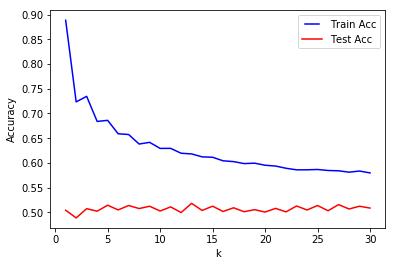


For K =  1 

train:  0.888676157243
test:  0.504268217246

Confusion matrix:
[[1806 1974]
 [2033 2270]]

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'):
             precision    recall  f1-score   support

       Away       0.47      0.48      0.47      3780
       Home       0.53      0.53      0.53      4303

avg / total       0.50      0.50      0.50      8083



For K =  2 

train:  0.72346601612
test:  0.488679945565

Confusion matrix:
[[2730 1050]
 [3083 1220]]

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform'):
             precision    recall  f1-score   support

       Away       0.47      0.72      0.57      3780
       Home       0.54      0.28      0.37      4303

avg / to

In [140]:
train_results = [0.88867615724299787, 0.72346601611956896, 0.73467560139579413, 0.68390822345057589, 0.68613161226569497, 0.65898774048111664, 0.65744372047061728, 0.63820523113979555, 0.64160207516289414, 0.6293425562795294, 0.6294351974801593, 0.61955346941296363, 0.6181947318037242, 0.61226569496340677, 0.61140104375752713, 0.60423679090881022, 0.60263101009789088, 0.59861655807059255, 0.59945032887626226, 0.59528147484791405, 0.59361393323657474, 0.58913627520612666, 0.58598647438470808, 0.58601735478491801, 0.58669672358953773, 0.58465861717567857, 0.58404100917147883, 0.58123089275237005, 0.5835160423679091, 0.57971775314208074]
test_results = [0.50426821724607196, 0.48867994556476557, 0.5073611282939503, 0.50228875417542995, 0.51441296548311266, 0.50488679945564763, 0.5137943832735371, 0.50760856117778053, 0.51230978597055543, 0.50265990350117529, 0.51094890510948909, 0.49956699245329705, 0.51812445874056667, 0.50377335147841151, 0.51243350241247065, 0.50167017196585428, 0.5092168749226772, 0.50117530619819373, 0.50538166522330819, 0.50055672398861806, 0.50797971050352597, 0.5009278733143635, 0.51280465173821599, 0.50476308301373252, 0.5137943832735371, 0.50315476926883584, 0.515650129902264, 0.50674254608437463, 0.51230978597055543, 0.50859829271310153]

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(range(1,31), train_results, 'b', label="Train Acc")
line2, = plt.plot(range(1,31), test_results, 'r', label="Test Acc")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.show()

for k in range(1, 6):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_data, train_labels.values.ravel())

    print('\nFor K = ', k, '\n')    
    print('train: ', accuracy_score(clf.predict(train_data),train_labels))
    print('test: ', accuracy_score(clf.predict(test_data),test_labels))

    test_predicted_labels = clf.predict(test_data)
    test_predicted_probs = clf.predict_proba(test_data)
    print("\nConfusion matrix:\n%s" % confusion_matrix(test_labels, test_predicted_labels))
    print("\nClassification report for classifier %s:\n%s\n"
    % (clf, classification_report(test_labels, test_predicted_labels))) 

## Naive Bayes <a name='nb' />

<a href='#top'>[Back to Contents]</a>

We next tried a Naive Bayes model:
* Training and making predictions are a lot faster due to a generative model
* NB pulls towards predicting better on Home team winning 
* Overall performance is also slightly better than KNN's 

In [141]:
print(list(train_data.columns))

['League_MLB', 'League_NBA', 'League_NCAAB', 'League_NCAAF', 'League_NFL', 'League_NHL', 'MLBet_Away', 'MLBet_Home', 'bet_risk_favorite', 'bet_risk_normal', 'bet_risk_underdog', 'win_past_30_all_sport', 'win_past_30_all_sport_percent', 'win_past_30_specific_risk', 'win_past_30_specific_risk_percent', 'win_past_30_specific_sport', 'win_past_30_specific_sport_percent', 'win_steak_all_sport', 'win_steak_specific_sport']


train:  0.527591637588
test:  0.527155759

Confusion matrix:



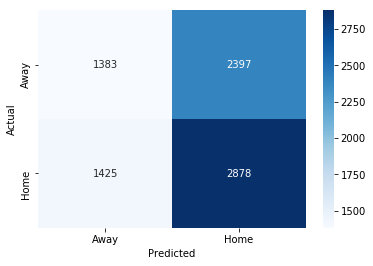


Classification report for classifier GaussianNB(priors=None):
             precision    recall  f1-score   support

       Away       0.49      0.37      0.42      3780
       Home       0.55      0.67      0.60      4303

avg / total       0.52      0.53      0.52      8083




In [142]:
clf=GaussianNB()
clf.fit(train_data,train_labels.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data),train_labels))
print('test: ', accuracy_score(clf.predict(test_data),test_labels))

test_predicted_labels = clf.predict(test_data)
test_predicted_probs = clf.predict_proba(test_data)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels, test_predicted_labels, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels, test_predicted_labels))) 

## Logistic Regression <a name='lr' />

<a href='#top'>[Back to Contents]</a>

Next, we got a bit improvement over NB from LR:
* prediction again, pulls towards predicting better on Home team winning 


train:  0.534539727635
test:  0.535197327725

Confusion matrix:



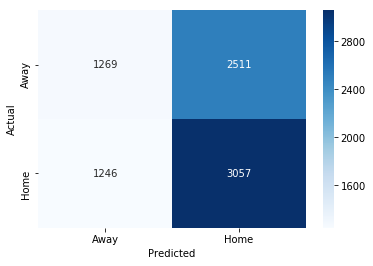


Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

       Away       0.50      0.34      0.40      3780
       Home       0.55      0.71      0.62      4303

avg / total       0.53      0.54      0.52      8083




In [143]:
clf=LogisticRegression()
clf.fit(train_data,train_labels.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data),train_labels))
print('test: ', accuracy_score(clf.predict(test_data),test_labels))

test_predicted_labels = clf.predict(test_data)
test_predicted_probs = clf.predict_proba(test_data)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels, test_predicted_labels, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels, test_predicted_labels))) 

## Random Forest <a name='rf' />

<a href='#top'>[Back to Contents]</a>

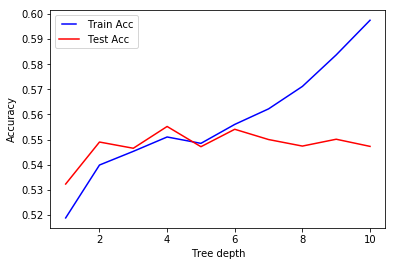

In [145]:
# let's try to find the optimal depth
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(train_data, train_labels.values.ravel())
    train_pred = rf.predict(train_data)
    train_acc = accuracy_score(rf.predict(train_data),train_labels)
    train_results.append(train_acc)
    y_pred = rf.predict(test_data)
    test_acc = accuracy_score(rf.predict(test_data),test_labels)
    test_results.append(test_acc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train Acc")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Acc")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

train:  0.550690176945
test:  0.55363107757

Confusion matrix:



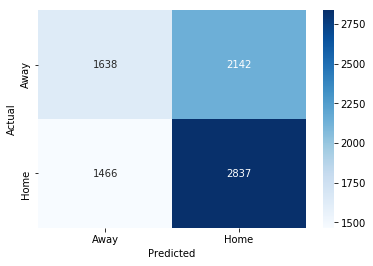


Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False):
             precision    recall  f1-score   support

       Away       0.53      0.43      0.48      3780
       Home       0.57      0.66      0.61      4303

avg / total       0.55      0.55      0.55      8083




In [146]:
# Instantiate model with 30 decision trees
clf = RandomForestClassifier(n_estimators = 30, random_state = 42, max_depth = 4)

# Train the model on training data
clf.fit(train_data, train_labels.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data),train_labels))
print('test: ', accuracy_score(clf.predict(test_data),test_labels))

test_predicted_labels = clf.predict(test_data)
test_predicted_probs = clf.predict_proba(test_data)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels, test_predicted_labels, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels, test_predicted_labels))) 

## Gradient Boosting Machine <a name='gbm' />

<a href='#top'>[Back to Contents]</a>

train:  0.54849766853
test:  0.554991958431

Confusion matrix:



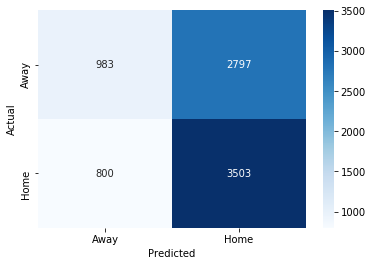


Classification report for classifier GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False):
             precision    recall  f1-score   support

       Away       0.55      0.26      0.35      3780
       Home       0.56      0.81      0.66      4303

avg / total       0.55      0.55      0.52      8083




In [148]:
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth = 4)
clf.fit(train_data, train_labels.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data),train_labels))
print('test: ', accuracy_score(clf.predict(test_data),test_labels))

test_predicted_labels = clf.predict(test_data)
test_predicted_probs = clf.predict_proba(test_data)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels, test_predicted_labels, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

#print("\nConfusion matrix:\n%s" % confusion_matrix(test_labels, test_predicted_labels))
print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels, test_predicted_labels))) 

## Support Vector Machines <a name='svm' />

<a href='#top'>[Back to Contents]</a>

Can't get this to run in a timely manner... it just takes forever to finish... 

In [22]:
# from sklearn.svm import SVC

# clf = SVC(kernel='rbf', C=1000, gamma=0.5)

# # Train the model on training data
# clf.fit(train_data, train_labels.values.ravel())

# print('train: ', accuracy_score(clf.predict(train_data),train_labels))
# print('test: ', accuracy_score(clf.predict(test_data),test_labels))

# test_predicted_labels = clf.predict(test_data)
# test_predicted_probs = clf.predict_proba(test_data)
# print("\nConfusion matrix:\n%s" % confusion_matrix(test_labels, test_predicted_labels))
# print("\nClassification report for classifier %s:\n%s\n"
# % (clf, classification_report(test_labels, test_predicted_labels))) 

## K-means Clustering <a name='kmeans' />

<a href='#top'>[Back to Contents]</a>

We attemped to look at unsupervised clustering techniques. However, 
* the 2 PCA breakdown showed that the points are not very spearable into clusters
* the two classes also overlap a lot

In [149]:
# Define Principal Components
model = PCA()
# Find them for the training data
model.fit(train_data)
# Cumulative fraction of total variance by the first k principal components for k in [1,50]
cumulative_variance = model.explained_variance_ratio_[:50].cumsum()
print(cumulative_variance)

[ 0.48412039  0.69148889  0.842508    0.9275075   0.96948535  0.9803991
  0.98816779  0.99530833  0.99787349  0.99886657  0.99932089  0.9996483
  0.99985012  0.99995191  0.9999954   1.          1.          1.          1.        ]


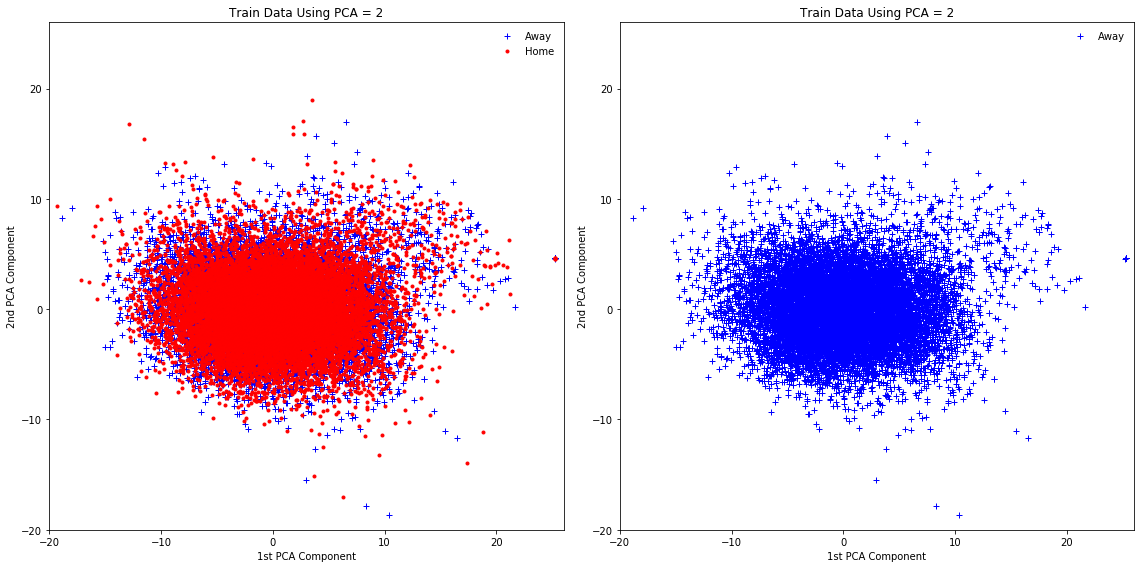

In [150]:
# Reduce train data to 2 dimensions
train_data_2pca = PCA(n_components=2).fit_transform(train_data)

# Plot transformed data
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
# set plotting range for x and y axis
plt.xlim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])
plt.ylim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])
# away (blue)
plt.plot(train_data_2pca[train_labels['MLWinner']=='Away'][:,0], train_data_2pca[train_labels['MLWinner']=='Away'][:,1], \
marker='+', color='b', ls='none', label="Away")
# home (red)
plt.plot(train_data_2pca[train_labels['MLWinner']=='Home'][:,0], train_data_2pca[train_labels['MLWinner']=='Home'][:,1], \
marker='.', color='r', ls='none', label="Home")
# Labels and legends
plt.xlabel('1st PCA Component')
plt.ylabel('2nd PCA Component')
plt.legend(frameon=False, numpoints=1)
plt.title('Train Data Using PCA = 2')

plt.subplot(1, 2, 2)
# set plotting range for x and y axis
plt.xlim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])
plt.ylim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])
# away (blue)
plt.plot(train_data_2pca[train_labels['MLWinner']=='Away'][:,0], train_data_2pca[train_labels['MLWinner']=='Away'][:,1], \
marker='+', color='b', ls='none', label="Away")
# Labels and legends
plt.xlabel('1st PCA Component')
plt.ylabel('2nd PCA Component')
plt.legend(frameon=False, numpoints=1)
plt.title('Train Data Using PCA = 2')

plt.tight_layout()

In [151]:
# train_data_2pca = PCA(n_components=2).fit_transform(train_data)

# # set figure size
# plt.figure(figsize = (21, 36))   

# # Iterate over [1, 5] clusters
# for k in range(1,7):
#     # K-means
#     km_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
#     km_model.fit(train_data_2pca)
#     # Distances of each data point to the centroids
#     dist = km_model.transform(train_data_2pca)

#     # Set up subplots, 6 rows up to 3 plots each row
#     ax = plt.subplot(6, 3, k)
#     plt.xlim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])
#     plt.ylim([np.floor(train_data_2pca.min()), np.ceil(train_data_2pca.max())])

#     # Iterate over each cluster center
#     for index, center in enumerate(km_model.cluster_centers_):
#         # Plot associated points in each cluster with a random RGB color
#         arr = (np.random.rand(), np.random.rand(), np.random.rand())
#         plt.plot(train_data_2pca[km_model.labels_==index][:,0], \
#                  train_data_2pca[km_model.labels_==index][:,1], \
#                  color=arr, alpha=0.5, ls='None', marker='.')
#         # Plot cluster center with black star
#         plt.plot(center[0], center[1], color='black', marker='*', markersize=10)
#         # Subset distance of points that correspond to the current center
#         center_subset = dist[km_model.labels_==index]
#         # Determine maximium distance
#         max_dist = np.amax(center_subset[:, index])        
#         # Plot circle with radius of max_dist around cluster center
#         circle = plt.Circle(center, max_dist, color=arr, ls='solid', zorder=1)
#         circle.set_alpha(0.2)
#         circle.set_edgecolor('black')
#         plt.gca().add_patch(circle)

#     # Labels and legends
#     plt.xlabel('1st PCA Component')
#     plt.ylabel('2nd PCA Component')
#     plt.legend(frameon=False, numpoints=1)

#     plt.title("k = " + str(k))

## Gaussian Mixture Model (GMM) <a name='gmm' />

<a href='#top'>[Back to Contents]</a>

Not really helpful for the same issues we had with K-means

In [152]:
# train_data_2pca = PCA(n_components=2).fit_transform(train_data)
# positives = train_data_2pca[train_labels['MLWinner']=='Away']  

# for component in range(1,5):
#     plt.figure(figsize = (4*5,3))
#     for k, v in enumerate(['spherical', 'diag', 'tied', 'full']):

#         # Adapt plotting code from reference above
#         # Fit GMM
#         gmm_model = GaussianMixture(n_components=component, covariance_type=v)
#         gmm_model.fit(positives)

#         # Display predicted scores by the model as a contour plot
#         x = np.linspace(-30., 30.)
#         y = np.linspace(-30., 30.)
#         X, Y = np.meshgrid(x, y)
#         static_diff = 1 / (1 + X)
#         XX = np.array([X.ravel(), Y.ravel()]).T
#         Z = -gmm_model.score_samples(XX)
#         Z = Z.reshape(X.shape)
#         # plot 4 different types of covariance matrix in a row
#         ax = plt.subplot(1, 4, k+1)

#         # Plot contour
#         CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0), 
#                          levels=np.logspace(0, 2, 10))
#         CB = plt.colorbar(CS, shrink=0.8, extend='both', format='%0.0f')
#         plt.plot(positives[:, 0], positives[:, 1], color="blue", ls='None', marker='+')
#         plt.title('n=' + str(component) + ' and ' + v + ' covariance matrix')
#         plt.xlabel("1st PCA")
#         plt.ylabel("2nd PCA")
#         plt.axis('tight')

## Multilayer Perceptron <a name='dnn' />

<a href='#top'>[Back to Contents]</a>

train:  0.520705308341
test:  0.53297043177

Confusion matrix:



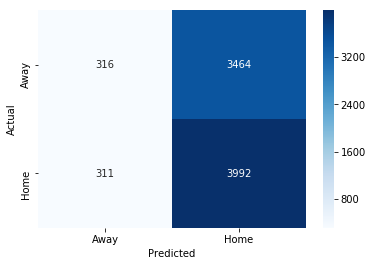


Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.01, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False):
             precision    recall  f1-score   support

       Away       0.50      0.08      0.14      3780
       Home       0.54      0.93      0.68      4303

avg / total       0.52      0.53      0.43      8083




In [168]:
# Initializing the multilayer perceptron
clf = MLPClassifier(hidden_layer_sizes =10,solver='sgd',learning_rate_init= 0.01 ,max_iter=500, random_state =42)

# Train the model
clf.fit(train_data, train_labels.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data),train_labels))
print('test: ', accuracy_score(clf.predict(test_data),test_labels))

test_predicted_labels = clf.predict(test_data)
test_predicted_probs = clf.predict_proba(test_data)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels, test_predicted_labels, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels, test_predicted_labels))) 

## Our Strategy For Money-Line Bets <a name='ensemble' />

<a href='#top'>[Back to Contents]</a>

We decided to use a combination of KNN and multilayer perceptron models to make bets. Specifically, because of their observed F1 scores, we will use the 2-NN on betting **away** and the MLP on betting **home**. We will compare the probabilities and choose the bigger one to represent the predicted class. 

In addition, to help see how much money we would win/lose, we tallied the wins/losses on the test data as follows:
* on win, we will get max(juice, 100)
* on loss, we will get min(juice,100)

**Findings**:
* Using our strategy, we will beat the handicappers' performance (-3972 vs. -15515)
* If we always bet home, as suggested by the MLP, we can actually win a lot... +10226 
  * we think it's because of the home court advantage in sports, so betting home is more likely to win

In [169]:
knn2_away = KNeighborsClassifier(n_neighbors=2)
knn2_away.fit(train_data, train_labels.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [170]:
mlp_home = MLPClassifier(hidden_layer_sizes =10,solver='sgd',learning_rate_init= 0.01 ,max_iter=500, random_state =42)
mlp_home.fit(train_data, train_labels.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.01, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [208]:
predicted_labels = pd.DataFrame(dict(knn_away = [i[0] for i in knn2_away.predict_proba(test_data)], mlp_home = [i[1] for i in mlp_home.predict_proba(test_data)]))
predicted_labels['PredictedMLWinner'] = np.where(predicted_labels['knn_away']>predicted_labels['mlp_home'], 'Away', 'Home')

In [219]:
predicted_labels.head()

,knn_away,mlp_home,PredictedMLWinner
0,0.5,0.488883,Away
1,0.5,0.469669,Away
2,0.5,0.515928,Home
3,0.5,0.508002,Home
4,0.0,0.520273,Home


In [211]:
testgames = test_games[['League', 'GameKey', 'Juice', 'Result', 'MLBet', 'MLWinner', 'Handicapper']].reset_index(drop=True)

In [212]:
testgames_with_predictions = testgames.join(predicted_labels['PredictedMLWinner'])

In [227]:
tally = testgames_with_predictions.pivot_table(values=['League','Juice', 'MLBet', 'MLWinner', 'Handicapper', 'PredictedMLWinner'], index=['GameKey'], aggfunc='first')

In [228]:
tally['HC_Win_Loss'] = np.where(tally['MLBet']==tally['MLWinner'], 'Win', 'Loss')
tally['Pred_Win_Loss'] = np.where(tally['PredictedMLWinner']==tally['MLWinner'], 'Win', 'Loss')

In [229]:
tally.Juice = pd.to_numeric(tally.Juice)
tally['HC_Payout'] = tally.apply(lambda row: min(row['Juice'], -100) if row['HC_Win_Loss']=='Loss' else max(row['Juice'], 100), axis=1)
tally['Pred_Payout'] = tally.apply(lambda row: min(row['Juice'], -100) if row['Pred_Win_Loss']=='Loss' else max(row['Juice'], 100), axis=1)

In [235]:
print("HC tallied payout: ", tally.HC_Payout.sum())
print("Our strategy tallied payout: ", tally.Pred_Payout.sum())

HC tallied payout:  -15515
Our strategy tallied payout:  -3972


In [236]:
tally['AlwaysBetHome'] = 'Home'

In [237]:
tally['AlwaysHome_Win_Loss'] = np.where(tally['AlwaysBetHome']==tally['MLWinner'], 'Win', 'Loss')
tally['AlwaysHome_Payout'] = tally.apply(lambda row: min(row['Juice'], -100) if row['AlwaysHome_Win_Loss']=='Loss' else max(row['Juice'], 100), axis=1)
print("Always bet 'Home' tallied payout: ", tally.AlwaysHome_Payout.sum())

Always bet 'Home' tallied payout:  10226


## Appendix A  <a name='appendix_a' />

<a href='#top'>[Back to Contents]</a>

#### Feature Importance From Random Forest Model

In [120]:
# Saving feature names for later use
feature_list = list(train_data.columns)

# Convert to numpy array
features = np.array(features)

# Instantiate model with 30 decision trees
clf = RandomForestClassifier(n_estimators = 30, random_state = 42, max_depth = 4)

# Train the model on training data
clf.fit(train_data, train_labels.values.ravel())

# Get numerical feature importances
importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MLBet_Home                     Importance: 0.1623
Variable: bet_risk_favorite              Importance: 0.1606
Variable: bet_risk_underdog              Importance: 0.1477
Variable: bet_risk_normal                Importance: 0.1065
Variable: MLBet_Away                     Importance: 0.1062
Variable: win_past_30_specific_risk_percent Importance: 0.0763
Variable: win_past_30_specific_risk      Importance: 0.0544
Variable: win_past_30_specific_sport_percent Importance: 0.0406
Variable: win_steak_all_sport            Importance: 0.0362
Variable: win_past_30_all_sport_percent  Importance: 0.0275
Variable: win_past_30_all_sport          Importance: 0.0244
Variable: win_steak_specific_sport       Importance: 0.0182
Variable: win_past_30_specific_sport     Importance: 0.0179
Variable: League_MLB                     Importance: 0.0057
Variable: League_NCAAB                   Importance: 0.0057
Variable: League_NFL                     Importance: 0.0032
Variable: League_NHL             

## Appendix B  <a name='appendix_a' />

<a href='#top'>[Back to Contents]</a>

#### Random Forest Model on Pivoted Data & Feature Importance

train:  0.553496011262
test:  0.530465949821

Confusion matrix:



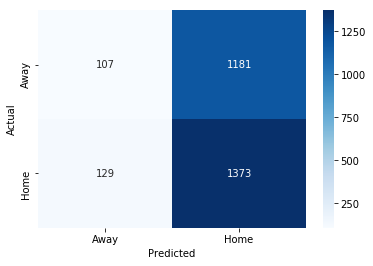


Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False):
             precision    recall  f1-score   support

       Away       0.45      0.08      0.14      1288
       Home       0.54      0.91      0.68      1502

avg / total       0.50      0.53      0.43      2790


Variable: A2_HC11                        Importance: 0.027
Variable: A4_HC7                         Importance: 0.0213
Variable: A0_HC13_Home                   Importance: 0.0208
Variable: A0_HC13_Away                   Importance: 0.0198
Variable: A9_HC15                        Importance: 0.0187
Variable: A7_HC9_favorite                I

In [137]:
# Let MLBet be A0
# Let win_past_30_all_sport be A1
# Let win_past_30_all_sport_percent be A2
# Let win_past_30_specific_sport be A3
# Let win_past_30_specific_sport_percent be A4
# Let win_steak_all_sport be A5
# Let win_steak_specific_sport be A6
# Let bet_risk be A7
# Let win_past_30_specific_risk be A8
# Let win_past_30_specific_risk_percent be A9

# Saving feature names for later use
feature_list = list(train_data_pivoted.columns)

# Convert to numpy array
features = np.array(features)

# Instantiate model with 30 decision trees
clf = RandomForestClassifier(n_estimators = 30, random_state = 42, max_depth = 4)

# Train the model on training data
clf.fit(train_data_pivoted, train_labels_pivoted.values.ravel())

print('train: ', accuracy_score(clf.predict(train_data_pivoted),train_labels_pivoted))
print('test: ', accuracy_score(clf.predict(test_data_pivoted),test_labels_pivoted))

test_predicted_labels = clf.predict(test_data_pivoted)
test_predicted_probs = clf.predict_proba(test_data_pivoted)

print("\nConfusion matrix:\n")
labels = ['Away', 'Home']
cm = confusion_matrix(test_labels_pivoted, test_predicted_labels, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print("\nClassification report for classifier %s:\n%s\n"
% (clf, classification_report(test_labels_pivoted, test_predicted_labels))) 

# Get numerical feature importances
importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];